<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [9]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [10]:
for_knn = X_train.todense()

In [11]:
train_cv_score = cross_val_score(knn, for_knn, y_train, cv=skf, scoring="accuracy").mean()

In [12]:
knn.fit(for_knn, y_train)
test_score = accuracy_score(y_valid, knn.predict(X_valid.todense()))

In [13]:
answer1 = list(map(lambda x: str(round(x, 3)), [train_cv_score, test_score]))

In [14]:
with open("answer_1.txt", 'w') as file:
    file.write(" ".join(answer1))

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, 
                                oob_score=True, n_jobs=-1)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [17]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=17, verbose=0,
                       warm_start=False)

In [18]:
test_score = accuracy_score(y_valid, forest.predict(X_valid))

In [19]:
def write_answer(num, values):
    answer = list(map(lambda x: str(round(x, 3)), values))
    with open(f"answer_{num}.txt", 'w') as file:
        file.write(" ".join(answer))

In [20]:
write_answer(2, [forest.oob_score_, test_score])

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [22]:
logit = LogisticRegression(random_state=17)

train_cv = cross_val_score(logit, X_train, y_train, cv=skf, scoring="accuracy").mean()

logit.fit(X_train, y_train)
valid_result = accuracy_score(y_valid, logit.predict(X_valid))

In [23]:
print(f"train result: {train_cv}, valid result: {valid_result}")

train result: 0.7625486713048025, valid result: 0.7817018250770325


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [24]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf,
                                           multi_class="multinomial", random_state=17,
                                           n_jobs=-1, scoring="accuracy")
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 8.87 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [25]:
logit_mean_cv_scores1 = list(v.mean(axis=0) for k, v in logit_grid_searcher1.scores_.items())[0]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [26]:
print(f"best score {max(logit_mean_cv_scores1)} and C value {logit_grid_searcher1.C_[0]}")

best score 0.762446642549247 and C value 4.641588833612772


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

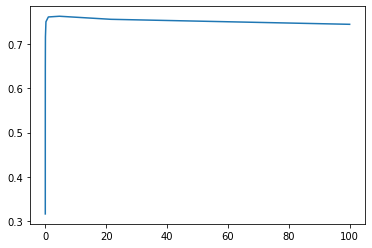

In [27]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [28]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf,
                                           multi_class="multinomial", random_state=17,
                                           n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 22.9 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [29]:
logit_mean_cv_scores2 = list(v.mean(axis=0) for k, v in logit_grid_searcher2.scores_.items())[0]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [30]:
print(f"best score {max(logit_mean_cv_scores2)} and C value {logit_grid_searcher2.C_[0]}")

best score 0.7636661867188504 and C value 1.5526315789473686


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

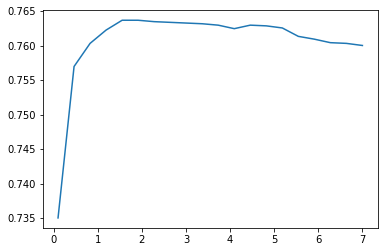

In [31]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [32]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
print("score: ", logit_cv_acc)

score:  0.7788575491822707


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [33]:
write_answer(3, [max(logit_mean_cv_scores2), logit_cv_acc])

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [34]:
from sklearn.svm import LinearSVC

In [35]:
svm = LinearSVC(C=1, random_state=17)
svm_score = cross_val_score(logit, X_train, y_train, cv=skf, scoring="accuracy").mean()

svm.fit(X_train, y_train)
svm_valid = accuracy_score(y_valid, svm.predict(X_valid))

print(f"train result: {svm_score}, valid result: {svm_valid}")

train result: 0.7625486713048025, valid result: 0.7769613652524295


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [36]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, scoring="accuracy",
                                 n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 24.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [37]:
print(f"best score {svm_grid_searcher1.best_score_} and best C {svm_grid_searcher1.best_params_['C']}")

best score 0.6890875838244259 and best C 1111.1112


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

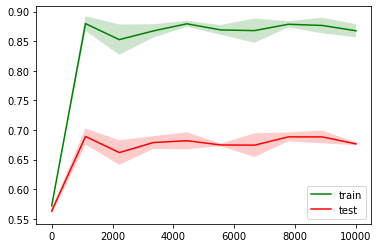

In [38]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [39]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, scoring="accuracy",
                                 n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 29.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.001     ,...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='acc

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [40]:
print(f"best score {svm_grid_searcher2.best_score_} and best C {svm_grid_searcher2.best_params_['C']}")

best score 0.7649867913025807 and best C 0.24213793103448275


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

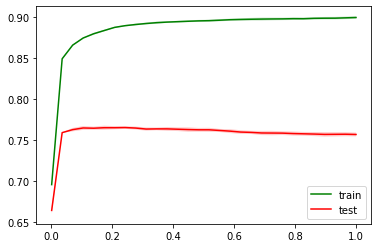

In [41]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [42]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [43]:
write_answer(4, [svm_grid_searcher2.best_score_, svm_cv_acc])

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [44]:
import time

In [45]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    
    '''
    
    start = time.time()
    
    x_pkl = open(path_to_X_pickle, "rb")
    y_pkl = open(path_to_y_pickle, "rb")
    X_sparse = pickle.load(x_pkl)
    y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    CV_accuracy = cross_val_score(estimator, X_train, y_train, 
                                  cv=cv, scoring="accuracy").mean()
    
    estimator.fit(X_train, y_train)
    accuracy = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return CV_accuracy, accuracy, time.time() - start

**Убедитесь, что функция работает.**

In [46]:
res = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, 
                                  cv=skf, scoring="accuracy").mean()
print(f"best score {res} and {svm_cv_acc}")

best score 0.7649865831742932 and 0.7835980090068737


In [47]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7649865831742932, 0.7835980090068737, 3.9443488121032715)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [48]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                                     f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                                     f'y_10users_s{session_length}_w{window_size}.pkl')
        
        cv_acc, acc, sp_time = model_assessment(svm_grid_searcher2.best_estimator_, 
                                             path_to_X_pkl, path_to_y_pkl,skf,
                                             random_state=17, test_size=0.3)
        
        print(f"window size={window_size}, session length={session_length}, \n\
              cross_val_acc: {cv_acc}, accurcay: {acc}, time: {sp_time}")

window size=10, session length=15, 
              cross_val_acc: 0.8190452553622495, accurcay: 0.8416686418582603, time: 6.014250993728638
window size=10, session length=10, 
              cross_val_acc: 0.7649865831742932, accurcay: 0.7835980090068737, time: 5.619012117385864
window size=7, session length=15, 
              cross_val_acc: 0.8472949188343161, accurcay: 0.8592998174879708, time: 8.066719055175781
window size=7, session length=10, 
              cross_val_acc: 0.8025564237115859, accurcay: 0.8070350091256014, time: 5.308503150939941
window size=7, session length=7, 
              cross_val_acc: 0.7551189999597661, accurcay: 0.7511199601791936, time: 3.2500743865966797
window size=5, session length=15, 
              cross_val_acc: 0.8720160425233194, accurcay: 0.880393551446183, time: 10.87332558631897
window size=5, session length=10, 
              cross_val_acc: 0.8155681702373564, accurcay: 0.8283546704599336, time: 7.2105488777160645
window size=5, session length=7,

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [49]:
write_answer(5, [0.8720160425233194, 0.880393551446183])

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [50]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7)]:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                                     f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                                     f'y_150users_s{session_length}_w{window_size}.pkl')
        
        cv_acc, acc, sp_time = model_assessment(svm_grid_searcher2.best_estimator_, 
                                             path_to_X_pkl, path_to_y_pkl,skf,
                                             random_state=17, test_size=0.3)
        
        print(f"window size={window_size}, session length={session_length}, \n\
              cross_val_acc: {cv_acc}, accurcay: {acc}, time: {sp_time}")

window size=5, session length=5, 
              cross_val_acc: 0.4113590745976674, accurcay: 0.4230666277315423, time: 542.9325993061066
window size=7, session length=7, 
              cross_val_acc: 0.43751731640896385, accurcay: 0.45236229859999316, time: 433.17919993400574
Wall time: 16min 16s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [51]:
path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                                 f'X_sparse_150users.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                                     f'y_150users.pkl')
        
cv_acc, acc, sp_time = model_assessment(svm_grid_searcher2.best_estimator_, 
                                             path_to_X_pkl, path_to_y_pkl,skf,
                                             random_state=17, test_size=0.3)
        

In [52]:
write_answer(6, [0.4602495609116246, 0.4841628959276018])

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [53]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [54]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [97]:
logit_grid_searcher2.Cs[10]

3.7315789473684213

In [98]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs[10]], cv=skf,
                                           multi_class="ovr", random_state=17,
                                           n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 4min 45s


LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [118]:
cv_scores_by_user1 = logit_cv_150users.scores_
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))

User 1, CV score: 0.9960793346553416
User 2, CV score: 0.9963509534561782
User 3, CV score: 0.9952039715108505
User 4, CV score: 0.9920242525060452
User 5, CV score: 0.9904076911403137
User 6, CV score: 0.9942447330306018
User 7, CV score: 0.9935983376625162
User 8, CV score: 0.9860602484886853
User 9, CV score: 0.9979149213024526
User 10, CV score: 0.9951313515924252
User 11, CV score: 0.9942453108161621
User 12, CV score: 0.9936193152035542
User 13, CV score: 0.9969451635892863
User 14, CV score: 0.9946719907486496
User 15, CV score: 0.9962258117704225
User 16, CV score: 0.9963507844291443
User 17, CV score: 0.9904708257226696
User 18, CV score: 0.9944011192344542
User 19, CV score: 0.9945158525342351
User 20, CV score: 0.9914816590283939
User 21, CV score: 0.9810038304200542
User 22, CV score: 0.99694520088749
User 23, CV score: 0.9948082807971695
User 24, CV score: 0.9911066107455389
User 25, CV score: 0.9967263654154571
User 26, CV score: 0.9942448783314676
User 27, CV score: 0.99

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [119]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    const_score = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(f'User {user_id}, CV score: {cv_scores_by_user[user_id].mean() - const_score}')
    acc_diff_vs_constant.append(cv_scores_by_user[user_id].mean() - const_score)

User 1, CV score: 0.011676803194538565
User 2, CV score: 0.000646512973657587
User 3, CV score: 0.0008027954450408048
User 4, CV score: 0.007308937585231545
User 5, CV score: 0.002460280466056841
User 6, CV score: -0.00020857361187631707
User 7, CV score: 0.0010530101261029268
User 8, CV score: 0.0021477444485656916
User 9, CV score: 0.0007925291345504126
User 10, CV score: 0.001303611869968302
User 11, CV score: 9.436151836095252e-05
User 12, CV score: 0.0015744412031579724
User 13, CV score: 2.0867612724240203e-05
User 14, CV score: -0.00018793439184228156
User 15, CV score: -0.0001250478627867757
User 16, CV score: 0.000156316525940281
User 17, CV score: 0.00039648752034049384
User 18, CV score: 0.0002501699366530552
User 19, CV score: -0.0002293853375862076
User 20, CV score: 0.0010424067893856082
User 21, CV score: 0.00400384084616956
User 22, CV score: 0.0009279769449587194
User 23, CV score: 0.007590698196270784
User 24, CV score: 0.0011052553505455087
User 25, CV score: 0.00078

In [120]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()
num_better_than_default

121

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [121]:
write_answer(7, [num_better_than_default/len(acc_diff_vs_constant)])

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [190]:
y_binary_128 = y_150users == 1
y_binary_128.astype('int')

array([1, 1, 1, ..., 0, 0, 0])

In [193]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [194]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users,
                                             y_binary_128,
                                             cv=skf,n_jobs=-1)

Wall time: 3.67 s


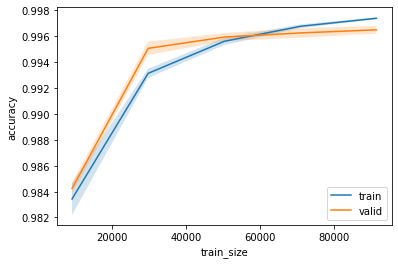

In [195]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.